# レスラー方程式(ランダムなシフト付きsin外力のある状態)

レスラー方程式の外力のある場合に関して，$\sin$ 波に位相のランダムなシフトがある場合を考える．

In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [34]:
shift_hour = -10

In [35]:
dir_name = f"data_definite"

filename_with_force = f"{dir_name}/VDP_{shift_hour}.csv"

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values

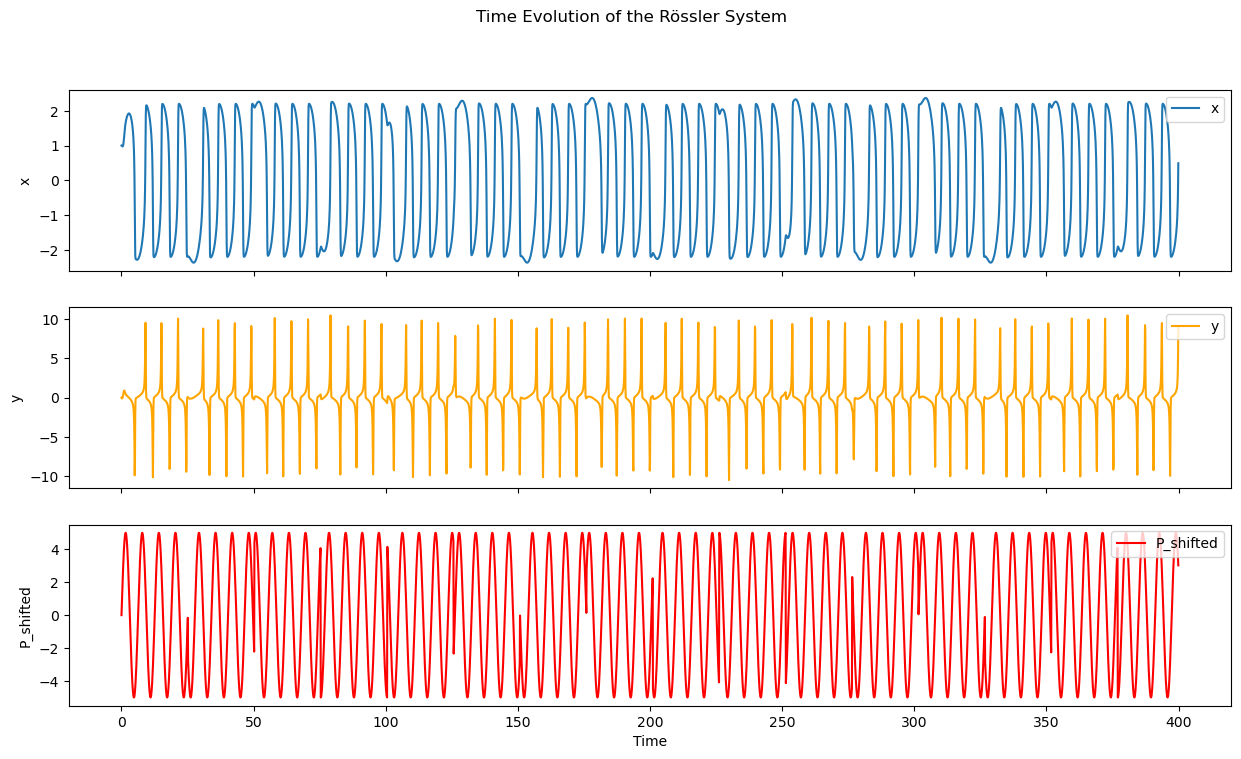

In [36]:
sample = 0
plot_length = 4000

# 時間ごとのx, y, P_shifted それぞれのグラフ
fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['x'][sample: sample+plot_length], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['y'][sample: sample+plot_length], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

axs[2].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['P_shifted'][sample: sample+plot_length], label='P_shifted', color='red')
axs[2].set_ylabel('P_shifted')
axs[2].set_xlabel('Time')
axs[2].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()


生成データの描画．　

In [37]:
import pandas as pd

# CSVファイルを読み込む際にヘッダーがないことを指定
filename_with_force_result = f"VDP_random_det_gen/VDP_shift{shift_hour}.csv"
data_loaded_with_force_result = pd.read_csv(filename_with_force_result, header=None)

# 0, 1, 2列目を抽出してNumpy配列に格納
X_result = data_loaded_with_force_result.iloc[:, [0, 1, 2]].values

filename_with_force_val = f"VDP_random_det_val/VDP_shift{shift_hour}.csv"
data_loaded_with_force_val = pd.read_csv(filename_with_force_val, header=None)

# 0, 1, 2列目を抽出してNumpy配列に格納
X_val = data_loaded_with_force_val.iloc[:, [0, 1, 2]].values

In [38]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):
    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations) + seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    # `warming_inputs`のサイズを検証して調整します。
    if warming_inputs is not None and len(warming_inputs) > seed_timesteps:
        # `seed_timesteps`に合わせてサイズを調整
        warming_inputs = warming_inputs[:seed_timesteps]
        plt.plot(warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations) + seed_timesteps, np.abs(X_t - X_gen), label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup period")

    plt.legend()
    plt.show()


In [39]:
train_len = 20000
start_time = 0
test_length = 10000
nb_generations = 1000

seed_timesteps = test_length 


In [40]:
X_val_amp = X_val[:nb_generations]
X_result_amp = X_result[:nb_generations]

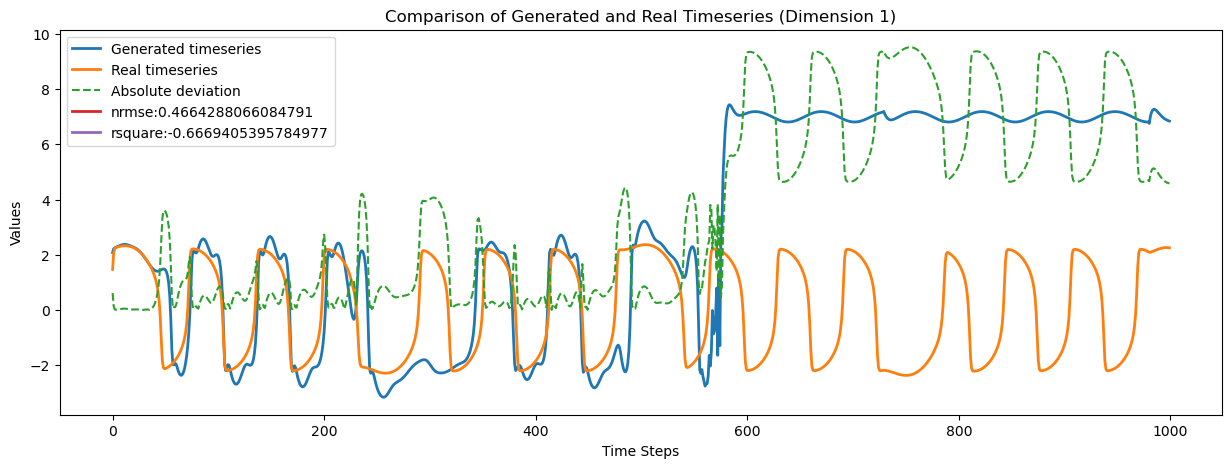

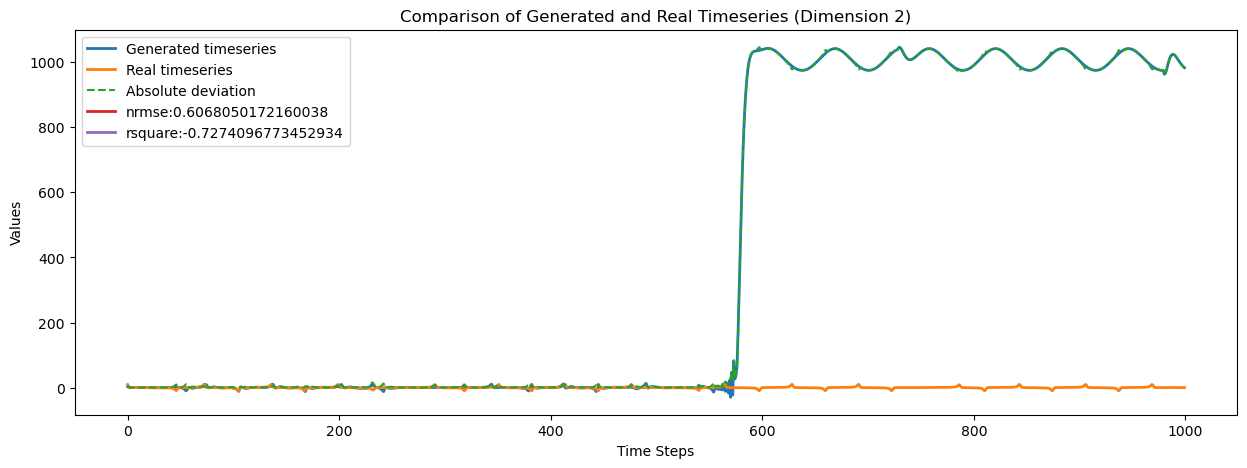

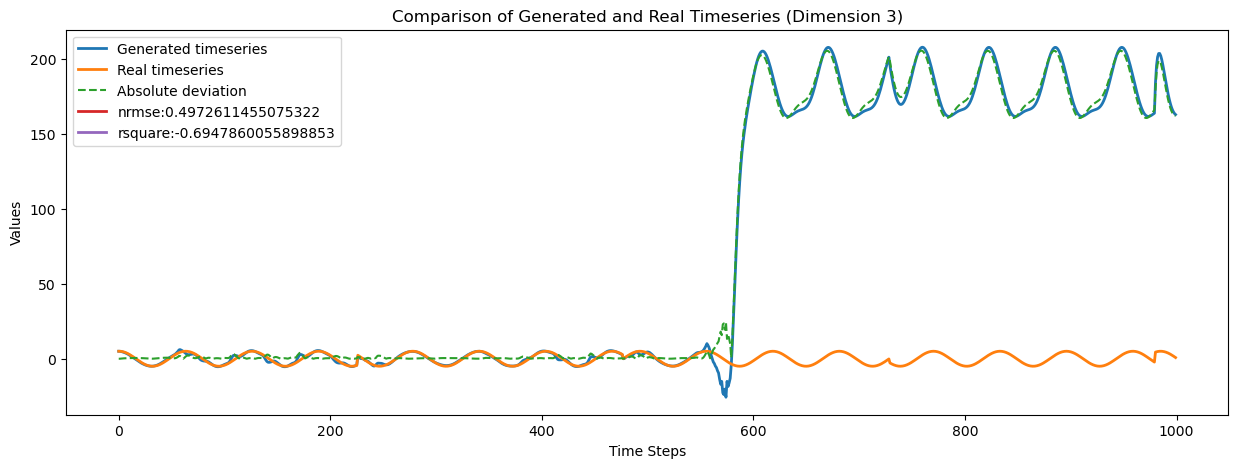

In [41]:
# 時系列データの比較を行う関数
def compare_timeseries_multidimensional(X_gen, X_t):
    num_dimensions = X_gen.shape[1]  # 次元数を取得
    for dim in range(num_dimensions):
        plt.figure(figsize=(15, 5))
        plt.plot(X_gen[:, dim][:1000], label="Generated timeseries", linewidth=2)
        plt.plot(X_t[:, dim][:1000], label="Real timeseries", linewidth=2)
        plt.plot(np.abs(X_t[:, dim][:1000] - X_gen[:, dim][:1000]), label="Absolute deviation", linestyle='--')
        plt.plot(nrmse(X_gen[:, dim][:1000], X_t[:, dim][:1000]), label=f"nrmse:{nrmse(X_gen[:, dim][:1000], X_t[:, dim][:1000])}", linewidth=2)
        plt.plot(rsquare(X_gen[:, dim][:1000], X_t[:, dim][:1000]), label=f"rsquare:{rsquare(X_gen[:, dim][:1000], X_t[:, dim][:1000])}", linewidth=2)

        plt.title(f'Comparison of Generated and Real Timeseries (Dimension {dim+1})')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()        
        plt.show()

# 使用例:
compare_timeseries_multidimensional(X_result_amp, X_val_amp)
